# Raster and geoparquet

## 1. Raster Data

Raster data is a `type of geospatial data model`. It represents the world as `a grid of cells (pixels)`, each cell containing a value.

Typical uses of raster data:
- storing satellite imagery,
- digital elevation models (DEM),
- climate data,
- land cover maps.

Each pixel may store:
- A continuous value (elevation, temperature, rainfall).
- A discrete class (land cover type: forest, water, urban).

Example: A 1000×1000 raster with 30 m resolution covers 30 km × 30 km of terrain.

Raster data model is a collection of various formats:
- NetCDF (Network Common Data Form): Climate/Weather, Remote sensing
- GeoTIFF: GIS maps
- ASCII Grid (ESRI .asc)
- HDF (Hierarchical Data Format, HDF4 / HDF5): Climate/Weather, Remote sensing
- ETc.
Standard in GIS, flexible, supports compression, multiple bands, large sizes.

### 1.1 NetCDF (Network Common Data Form)

**NetCDF** is a file format and data model, which stores `multi-dimensional arrays` (e.g., latitude × longitude × time × depth).

It has the below advantages:
- Self-describing: contains metadata describing variables, units, coordinate systems.
- Binary: Efficient for large spatiotemporal datasets (like daily temperature over decades).

It's commonly used in atmospheric reanalysis, global climate models, and remote sensing time series.

A NetCDF file defines:

- dimensions: It defines the shape of data arrays.
- variables: It stores the actual data.
- coordinates: 1D or 2D variables that define position.
- attributes: It stores the metadata at the file or variable level.

### 1.2 GeoTIFF

**GeoTIFF** is a `georeferenced raster image format` widely used in `geographic information systems (GIS)` to store spatial data such as satellite imagery, aerial photos, digital elevation models, and other gridded data.
GeoTIFF is compatible with TIFF viewers, but extended with `geographic tags(e.g. coordinate system, projection, geotransform)` following the GeoTIFF specification. Almost all GIS and remote sensing software can read/write GeoTIFF.

It can contain multiple bands (e.g., RGB, multispectral, or elevation).
It's widely supported by `GIS tools (e.g. QGIS, ArcGIS, GDAL, etc.)`.

Example: a Landsat scene distributed as GeoTIFF files, each band in a separate file.

### 1.3 ASCII Grid (ESRI .asc)

`ASCII Grid` is a simple text-based raster format.
It's easy to read but `inefficient for large datasets`.

### 1.4 HDF (Hierarchical Data Format, HDF4 / HDF5)

**HDF** is similar to `NetCDF`, designed for storing large scientific datasets.

> NASA distributes MODIS satellite products in HDF.

### 1.5 Data source in this tutorial

The `NetCDF` sample data(sea_surface_temperature_O1_2001-2002.nc) is from https://www.unidata.ucar.edu/software/netcdf/examples/files.html. It describes sea surface temperatures collected by `PCMDI` for use by the `IPCC`.


The `geotiff` sample data() is from https://www.planetobserver.com/geospatial-data-samples. It describes the global elevation of San Francisco USA.

## 2. Use sedona to read raster data

In this tutorial, we will use sedona to read various raster data formats, and try some raster operations.

The full API docs is [here](https://sedona.apache.org/latest/api/sql/Raster-operators/)

In [1]:
from sedona.spark import *
from pathlib import Path
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import expr

In [ ]:
import os
os.environ["PYSPARK_PYTHON"]="python"
os.environ["PYSPARK_DRIVER_PYTHON"]="python"

In [2]:
# build a sedona session offline
project_root_dir = Path.cwd().parent

print(project_root_dir.as_posix())

C:/Users/PLIU/Documents/git/Seminar_PySpark_Sedona_GeoParquet


In [4]:
# here we choose sedona 1.7.2 for spark 3.5.* build with scala 2.12
jar_folder = Path(f"{project_root_dir}/jars/sedona-35-212-172")
jar_list = [str(jar) for jar in jar_folder.iterdir() if jar.is_file()]
jar_path = ",".join(jar_list)

# build a sedona session (sedona = 1.7.2) offline
spark = SparkSession.builder \
    .appName("sedona_tutorial") \
    .master("local[*]") \
    .config("spark.jars", jar_path) \
    .getOrCreate()

In [5]:
# create a sedona context
sedona = SedonaContext.create(spark)
# get the spark context
sc = spark.sparkContext
# use utf as default encoding
sc.setSystemProperty("sedona.global.charset", "utf8")

In [3]:

raster_data_dir = f"{project_root_dir}/data/raster"
netcdf_sample = f"{raster_data_dir}/netcdf/sea_surface_temperature_O1_2001-2002.nc"
geotiff_sample = f"{raster_data_dir}/geotiff/PlanetDEM_3s_SanFrancisco.tif"
ascii_sample = f"{raster_data_dir}/sample.asc"

### 2.1 Read netcdf via sedona

We will use `RS_FromNetCDF` api to read netcdf data. This API reads the array data of the record variable in memory along with `all its dimensions`. Since the netCDF format has many variants, the reader might not work for your case.

This api has been tested for `netCDF classic (NetCDF 1, 2, 5) and netCDF4/HDF5 files`.



In [17]:
raw_netcdf = sedona.read.format("binaryFile").load(netcdf_sample)

In [18]:
raw_netcdf.show(5)

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/C:/Users/PL...|2025-06-16 11:42:...|2949152|[43 44 46 01 00 0...|
+--------------------+--------------------+-------+--------------------+



In [19]:
# we need to get the netcdf record info first
recordInfo = raw_netcdf.selectExpr("RS_NetCDFInfo(content) as record_info").first()[0]
print(recordInfo)

lon_bnds(lon=180, bnds=2)

lat_bnds(lat=170, bnds=2)

time_bnds(time=24, bnds=2)

tos(time=24, lat=170, lon=180)


In [20]:
# convert the binary column into raster column
netcdf_df = raw_netcdf.withColumn("raster", expr("RS_FromNetCDF(content, 'tos', 'lon', 'lat')"))

In [21]:
netcdf_df.select("raster").show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now let's check if sedona can work with the raster column or not
- The function `RS_PixelAsCentroid`: returns the centroid (point geometry) of the specified pixel's area. The pixel coordinates specified are 1-indexed. If `colX` and `rowY` are out of bounds for the raster, they are interpolated assuming the same skew and translate values.

In [25]:
netcdf_df_centroid_1_1 = netcdf_df.select("raster").withColumn("centroid", expr("RS_PixelAsCentroid(raster,1,1)"))
netcdf_df_centroid_1_1.show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [26]:
def get_raster_pixel_centroid(src_raster_df: DataFrame, grid_x: int, grid_y: int) -> DataFrame:
    """
    This function take a raster dataframe, and a pixel coordinates, then it returns the centroid of the pixel
    """
    return src_raster_df.select("raster").withColumn("centroid", expr(f"RS_PixelAsCentroid(raster,{grid_x},{grid_y})"))


def show_raster_pixel_centroid(src_raster_df: DataFrame, grid_x: int, grid_y: int) -> None:
    """
    This function take a raster dataframe, and a pixel coordinates, then it prints the centroid of the pixel
    """
    get_raster_pixel_centroid(src_raster_df, grid_x, grid_y).show(1, truncate=False, vertical=True)

In [28]:
netcdf_df_centroid_1_2 = get_raster_pixel_centroid(netcdf_df, 1, 2)
netcdf_df_centroid_1_2.show(1, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
show_raster_pixel_centroid(netcdf_df, 1, 3)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

We can notice the centroid of
- grid(1,1): POINT (1, 89.5)
- grid(1,2): POINT (1, 88.5)
- grid(1,3): POINT (1, 87.5)

### 2.2 Read geotiff with sedona

In [7]:
# read the raw geotiff file
raw_geotiff = sedona.read.format("binaryFile").load(geotiff_sample)

# you can notice the content of the geotiff file is read as binary column
raw_geotiff.show(5)


+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/C:/Users/PL...|2025-06-16 11:42:...|2890124|[49 49 2A 00 08 F...|
+--------------------+--------------------+-------+--------------------+



In [10]:
raw_geotiff.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [13]:
geotiff_df = raw_geotiff.withColumn("raster", expr("RS_FromGeoTiff(content)")).select("modificationTime", "raster",
                                                                                      "content")

In [14]:
geotiff_df.select("raster").show(1, truncate=False, vertical=True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 raster | GridCoverage2D["geotiff_coverage", GeneralEnvelope[(-123.0, 37.00000000000001), (-122.0, 38.0)], DefaultGeographicCRS["WGS 84"]]\r\n│   RenderedSampleDimension("GRAY_INDEX":[-32767.0 ... -32767.0])\r\n│     ‣ Category("No data":[-32767.0 ... -32767.0])\r\n└ Image=RenderedImageAdapter[]\r\n 



In [15]:
geotiff_df.printSchema()

root
 |-- modificationTime: timestamp (nullable = true)
 |-- raster: raster (nullable = true)
 |-- content: binary (nullable = true)



In [35]:
geotiff_df_polygon_1_1 = geotiff_df.select("raster").withColumn("polygon", expr("RS_PixelAsPolygon(raster,1,1)"))
geotiff_df_polygon_1_1.show(1, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 raster  | GridCoverage2D["geotiff_coverage", GeneralEnvelope[(-123.0, 37.00000000000001), (-122.0, 38.0)], DefaultGeographicCRS["WGS 84"]]\r\n│   RenderedSampleDimension("GRAY_INDEX":[-32767.0 ... -32767.0])\r\n│     ‣ Category("No data":[-32767.0 ... -32767.0])\r\n└ Image=RenderedImageAdapter[]\r\n 
 polygon | POLYGON ((-123 38, -122.99916666666667 38, -122.99916666666667 37.99916666666667, -123 37.99916666666667, -123 38))                                                                                                                                                                                



In [36]:
def get_raster_pixel_polygon(src_raster_df: DataFrame, grid_x: int, grid_y: int) -> DataFrame:
    """
    This function take a raster dataframe, and a pixel coordinates, then it returns the centroid of the pixel
    """
    return src_raster_df.select("raster").withColumn("polygon", expr(f"RS_PixelAsPolygon(raster,{grid_x},{grid_y})"))


def show_raster_pixel_polygon(src_raster_df: DataFrame, grid_x: int, grid_y: int) -> None:
    """
    This function take a raster dataframe, and a pixel coordinates, then it prints the centroid of the pixel
    """
    get_raster_pixel_centroid(src_raster_df, grid_x, grid_y).show(1, truncate=False, vertical=True)

In [37]:
geotiff_df_polygon_1_2 = get_raster_pixel_polygon(geotiff_df, 1, 2)
geotiff_df_polygon_1_2.show(1, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 raster  | GridCoverage2D["geotiff_coverage", GeneralEnvelope[(-123.0, 37.00000000000001), (-122.0, 38.0)], DefaultGeographicCRS["WGS 84"]]\r\n│   RenderedSampleDimension("GRAY_INDEX":[-32767.0 ... -32767.0])\r\n│     ‣ Category("No data":[-32767.0 ... -32767.0])\r\n└ Image=RenderedImageAdapter[]\r\n 
 polygon | POLYGON ((-123 37.99916666666667, -122.99916666666667 37.99916666666667, -122.99916666666667 37.998333333333335, -123 37.998333333333335, -123 37.99916666666667))                                                                                                                                 



In [38]:
geotiff_df_polygon_1_2.printSchema()

root
 |-- raster: raster (nullable = true)
 |-- polygon: geometry (nullable = true)



### 2.3 Read ASCII format


In [33]:
# read the asci file as binary
raw_ascii = sedona.read.format("binaryFile").load(ascii_sample)
raw_ascii.show(5)

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/C:/Users/PL...|2025-08-25 11:01:...|   181|[6E 63 6F 6C 73 2...|
+--------------------+--------------------+------+--------------------+



In [34]:
# convert the binary content column to raster column
ascii_df = raw_ascii.withColumn("raster", expr("RS_FromArcInfoAsciiGrid(content)"))
ascii_df.select("raster").show(1, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 raster | GridCoverage2D["AsciiGrid", GeneralEnvelope[(100.0, 200.0), (150.0, 240.0)], DefaultEngineeringCRS["Generic cartesian 2D"]]\r\n│   RenderedSampleDimension("AsciiGrid":[-9999.0 ... -9999.0])\r\n│     ‣ Category("No data":[-9999.0 ... -9999.0])\r\n└ Image=RenderedImageAdapter[]\r\n 



## Don't forget to close the spark session


In [ ]:
spark.stop()

## 3. Other python lib for working with raster data

There are many other python libraries which can read raster data:
- rasterio
- xarray


### 3.1 Use rasterio to read geotiff

In [39]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

In [42]:
def open_and_visualize_geotiff(file_path):
    """
    Open and visualize a GeoTIFF file with rasterio.
    """
    with rasterio.open(file_path) as src:
        # Read the first band
        data = src.read(1)

        # Print metadata
        print(f"Width: {src.width}, Height: {src.height}")
        print(f"Coordinate Reference System: {src.crs}")
        print(f"Bounds: {src.bounds}")

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Plot data with show() (passing array to get an AxesImage)
        image = show(data, ax=ax, transform=src.transform, cmap="viridis")
        ax.set_title("GeoTIFF Visualization")

        # Add colorbar
        cbar = plt.colorbar(image.get_images()[0], ax=ax, shrink=0.6)
        cbar.set_label("Value")

        # Example custom colormap (uncomment if needed)
        """
        colors = ['blue', 'green', 'yellow', 'red']
        cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

        fig, ax = plt.subplots(figsize=(12, 8))
        image = show(data, ax=ax, transform=src.transform, cmap=cmap)
        ax.set_title("GeoTIFF Visualization with Custom Colormap")
        cbar = plt.colorbar(image.get_images()[0], ax=ax, shrink=0.6)
        cbar.set_label("Value")
        plt.show()
        """

        plt.tight_layout()
        plt.show()

        return data, src.meta

Width: 1200, Height: 1200
Coordinate Reference System: EPSG:4326
Bounds: BoundingBox(left=-123.0, bottom=37.00000000000001, right=-122.0, top=38.0)


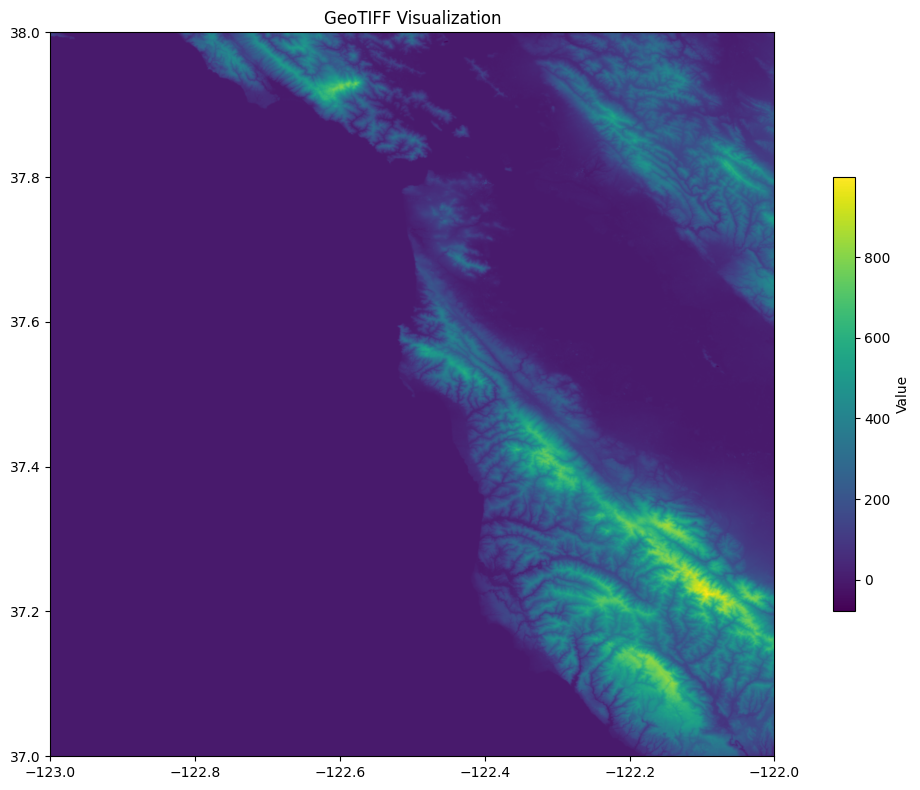

(array([[122, 113, 105, ...,  39,  35,  33],
        [139, 134, 124, ...,  45,  38,  38],
        [153, 142, 129, ...,  46,  44,  48],
        ...,
        [  0,   0,   0, ...,  49,  46,  83],
        [  0,   0,   0, ...,  44,  37,  82],
        [  0,   0,   0, ...,  30,  58,  88]], dtype=int16),
 {'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -32767.0,
  'width': 1200,
  'height': 1200,
  'count': 1,
  'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'),
  'transform': Affine(0.0008333333333333339, 0.0, -123.0,
         0.0, -0.0008333333333333281, 38.0)})

In [43]:
open_and_visualize_geotiff(geotiff_sample)

### 3.2 Use xarray to read netcdf

The package `xarray` is designed to work with `labelled multi-dimensional arrays`. It is particularly tailored to working with `netCDF files`, which were the source of xarray's data model.

But `xarray` uses other packages to handle the actual data IO engines. By default, it prefers `netcdf4` package (engine="netcdf4") if it is available.

If `netcdf4` is not installed, xarray can still work via `scipy (engine="scipy")`, but this engine has limitations: it can’t handle features like `compression, groups, or parallel I/O efficiently`.

Another option is `h5netcdf (engine="h5netcdf")`, which works well for `NetCDF4/HDF5` files and can be faster in some cases.

The package `scipy` is available inside CASD pypi server.

If you want to use `netcdf4`, what you can do?
1. Call service@casd.eu to add the package to CASD pypi server
2. Download the package, import it to your bulle, then install it offline.

> The package can be the source files or `wheel file(python project packaging format)`, it depends on the project release policies. Use can use the below command to let `pip` handle all for you.

#### 3.2.1 Download the required package

Before running the below command, you need to create a python virtual environment which has the same python version as your python environment in CASD bulle.

```shell

# -d option indicates where to put the downloaded file
pip download <package-name> -d "./py_dependencies"

# once the package is imported into the CASD bulle,
# install the required package from local sources
pip install --no-index --find-links ./py_dependencies
```

> A more detailed tutorial can be found [here](https://github.com/pengfei99/Learning_Python/blob/main/docs/Install_python_package_offline.md)

In [4]:
import xarray as xr

In [7]:
# Open the NetCDF file
ds = xr.open_dataset(netcdf_sample, engine="scipy")

# Show dataset structure
print(ds)

<xarray.Dataset> Size: 3MB
Dimensions:    (lon: 180, bnds: 2, lat: 170, time: 24)
Coordinates:
  * lon        (lon) float64 1kB 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat        (lat) float64 1kB -79.5 -78.5 -77.5 -76.5 ... 86.5 87.5 88.5 89.5
  * time       (time) object 192B 2001-01-16 00:00:00 ... 2002-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lon_bnds   (lon, bnds) float64 3kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    time_bnds  (time, bnds) object 384B ...
    tos        (time, lat, lon) float32 3MB ...
Attributes: (12/13)
    title:          IPSL  model output prepared for IPCC Fourth Assessment SR...
    institution:    IPSL (Institut Pierre Simon Laplace, Paris, France)
    source:         IPSL-CM4_v1 (2003) : atmosphere : LMDZ (IPSL-CM4_IPCC, 96...
    contact:        Sebastien Denvil, sebastien.denvil@ipsl.jussieu.fr
    project_id:     IPCC Fourth Assessment
    table_id:       Table O1 (13 November 2004)
    ...           

You can notice that it has four data variables:
- lon_bnds: (lon, bnds)
- lat_bnds: (lat, bnds)
- time_bnds: (time, bnds)
- tos: (time, lat, lon)

Now let's check the variable **tos**. The below code shows the details of variable `tos`

In [46]:
tos = ds["tos"]
print(tos)

<xarray.DataArray 'tos' (time: 24, lat: 170, lon: 180)> Size: 3MB
[734400 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 1kB 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * lat      (lat) float64 1kB -79.5 -78.5 -77.5 -76.5 ... 86.5 87.5 88.5 89.5
  * time     (time) object 192B 2001-01-16 00:00:00 ... 2002-12-16 00:00:00
Attributes:
    standard_name:   sea_surface_temperature
    long_name:       Sea Surface Temperature
    units:           K
    cell_methods:    time: mean (interval: 30 minutes)
    original_name:   sosstsst
    original_units:  degC
    history:          At   16:37:23 on 01/11/2005: CMOR altered the data in t...


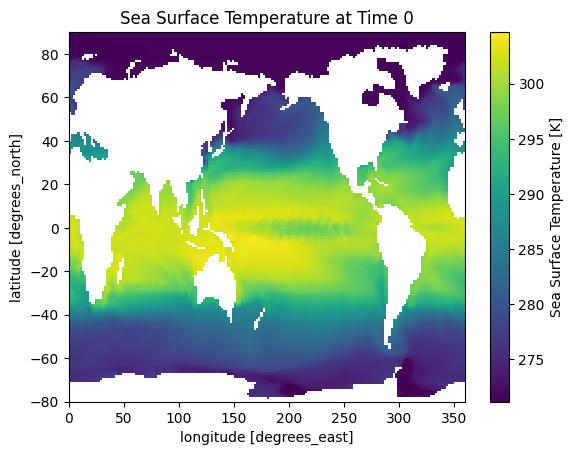

In [47]:
# Plot a 2D slice (e.g., first time step)
tos.isel(time=0).plot()  # Use correct dimension names like lat/lon
plt.title("Sea Surface Temperature at Time 0")
plt.show()

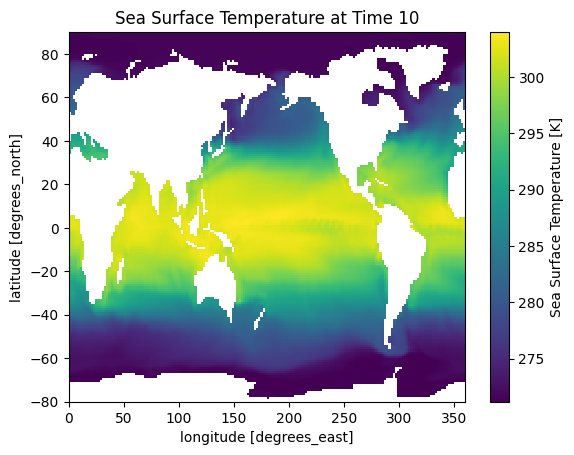

In [49]:
# Plot a 2D slice (e.g., first time step)
tos.isel(time=10).plot()  # Use correct dimension names like lat/lon
plt.title("Sea Surface Temperature at Time 10")
plt.show()

## 4. Optimize raster file disk usage

There are many ways to optimize the raster file disk usage. In this tutorial, we will show two possibilities:
- merge multi files into one: reduce duplicated metadata
- remove unnecessary precision

### 4.1 Create dummy NetCDF files for 3 days

In below code, we generate three netcdf files `day1.nc, day2.nc, and day3.nc`.

In [51]:
import xarray as xr
import numpy as np
import pandas as pd


In [55]:
tmp_path = f"{project_root_dir}/data/tmp"
print(tmp_path)

C:\Users\PLIU\Documents\git\Seminar_PySpark_Sedona_GeoParquet/data/tmp


In [56]:
start_date = "2025-01-01"
# Define dimensions
lat = np.array([10.0, 20.0], dtype=np.float64)
lon = np.array([30.0, 40.0], dtype=np.float64)
time = pd.date_range(start_date, periods=3)

# Generate dummy temperature data

for i, t in enumerate(time):
    temperature_data = np.random.uniform(280, 300, size=(2, 2)).astype(np.float64)
    humidity_data = np.random.uniform(30, 80, size=(2, 2)).astype(np.float64)
    # Create dataset
    ds = xr.Dataset(
        data_vars={
            "temperature": (["lat", "lon"], temperature_data),
            "humidity": (["lat", "lon"], humidity_data),
        },
        coords={
            "lat": ("lat", lat),
            "lon": ("lon", lon),
            "time": t,
        },
        attrs={
            "title": "Temperature sample Dataset",
            "institution": "CASD Meteorological Center",
            "source": "Simulated data",
            "history": f"Created {pd.Timestamp.now().strftime('%Y-%m-%d')}",
            "Conventions": "CF-1.8"
        }
    )

    # Add variable attributes
    ds["temperature"].attrs = {
        "long_name": "Surface Air Temperature",
        "units": "K",
        "_FillValue": -999.0
    }
    ds["humidity"].attrs = {
        "long_name": "Surface Air Humidity",
        "units": "%",
        "_FillValue": -1.0
    }

    ds["lat"].attrs = {
        "units": "degrees_north",
        "long_name": "latitude"
    }
    ds["lon"].attrs = {
        "units": "degrees_east",
        "long_name": "longitude"
    }
    ds["time"].attrs = {"long_name": "time"}
    encoding = {
        "temperature": {"zlib": True, "complevel": 4},
        "humidity": {"zlib": True, "complevel": 4}
    }

    # Save as NetCDF
    print(ds)
    ds.to_netcdf(f'{tmp_path}/day{i + 1}.nc', engine='netcdf4', encoding=encoding)

<xarray.Dataset> Size: 104B
Dimensions:      (lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
    time         datetime64[ns] 8B 2025-01-01
Data variables:
    temperature  (lat, lon) float64 32B 286.6 282.3 289.2 282.0
    humidity     (lat, lon) float64 32B 34.83 56.02 37.09 74.88
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-08-25
    Conventions:  CF-1.8
<xarray.Dataset> Size: 104B
Dimensions:      (lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
    time         datetime64[ns] 8B 2025-01-02
Data variables:
    temperature  (lat, lon) float64 32B 287.7 298.6 283.7 291.4
    humidity     (lat, lon) float64 32B 66.6 52.77 59.67 60.34
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological

### 4.2: Merge these files with a time dimension

You can notice we merge the three netcdf files into a single one. We almost saved the 70% disk usage.

In [57]:
files = ['day1.nc', 'day2.nc', 'day3.nc']
merged_file_path = f'{tmp_path}/merged_temperature.nc'
data_list = [xr.open_dataset(f"{tmp_path}/{file}", engine="netcdf4") for file in files]

merged = xr.concat(data_list, dim='time')

# Step 3: Save the merged dataset
merged.to_netcdf(merged_file_path, engine='netcdf4')

# Optional: Print dataset summary
print(merged)

<xarray.Dataset> Size: 248B
Dimensions:      (time: 3, lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
  * time         (time) datetime64[ns] 24B 2025-01-01 2025-01-02 2025-01-03
Data variables:
    temperature  (time, lat, lon) float64 96B 286.6 282.3 289.2 ... 298.0 298.1
    humidity     (time, lat, lon) float64 96B 34.83 56.02 37.09 ... 71.39 50.54
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-08-25
    Conventions:  CF-1.8


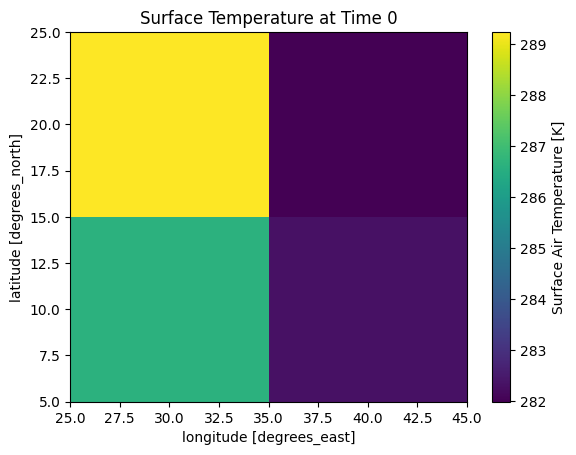

In [58]:
# you can check if the merged file contains all the values
from matplotlib import pyplot as plt

merged_ds = xr.open_dataset(merged_file_path, engine="netcdf4")
temperature = merged_ds["temperature"]

time = 0
# Plot a 2D slice (e.g., first time step)
temperature.isel(time=time).plot()  # Use correct dimension names like lat/lon
plt.title(f"Surface Temperature at Time {time}")
plt.show()

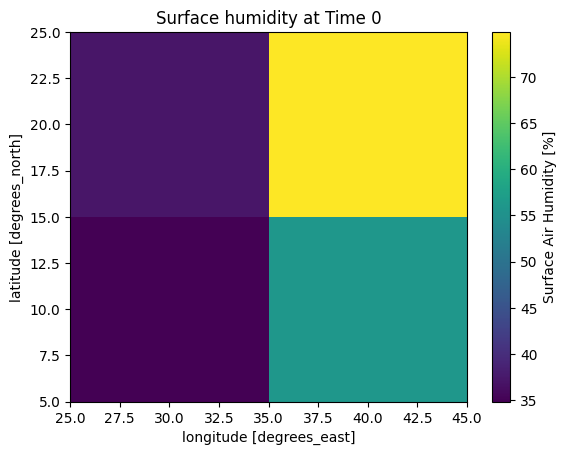

In [59]:
humidity = merged_ds["humidity"]

# Plot a 2D slice (e.g., first time step)
humidity.isel(time=time).plot()  # Use correct dimension names like lat/lon
plt.title(f"Surface humidity at Time {time}")
plt.show()

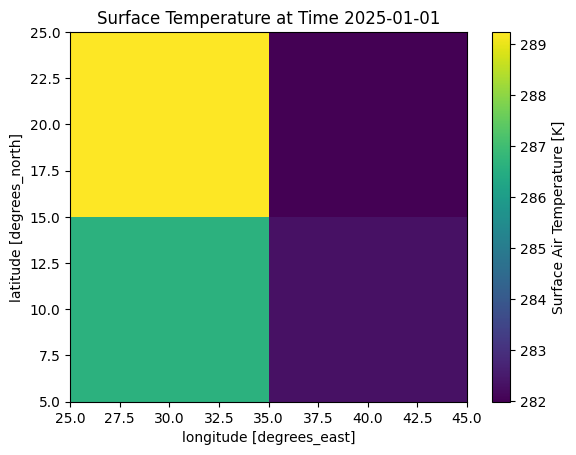

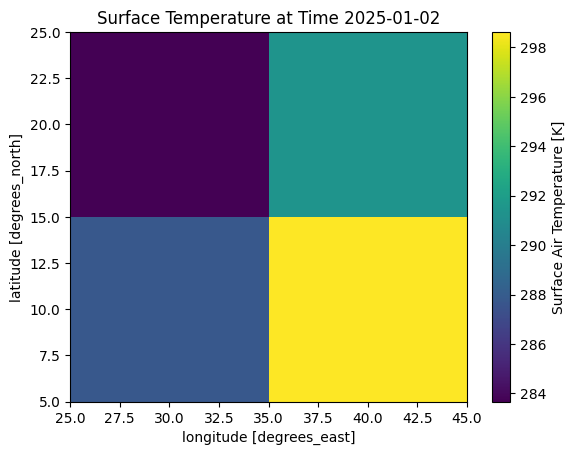

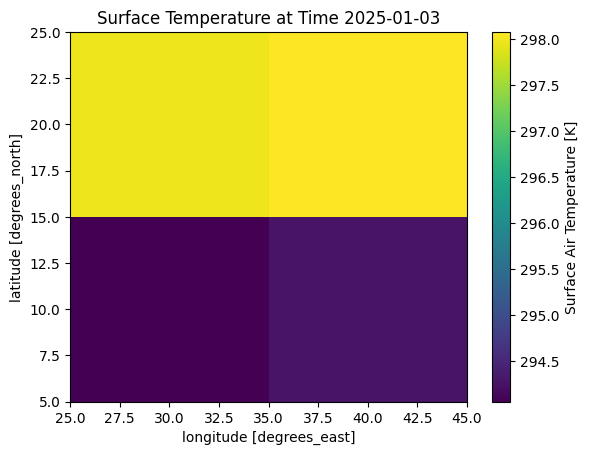

In [60]:
# all three days temperature
for t in range(len(temperature.time)):
    plt.figure()
    temperature.isel(time=t).plot()
    plt.title(f"Surface Temperature at Time {str(temperature.time.values[t])[:10]}")
    plt.show()

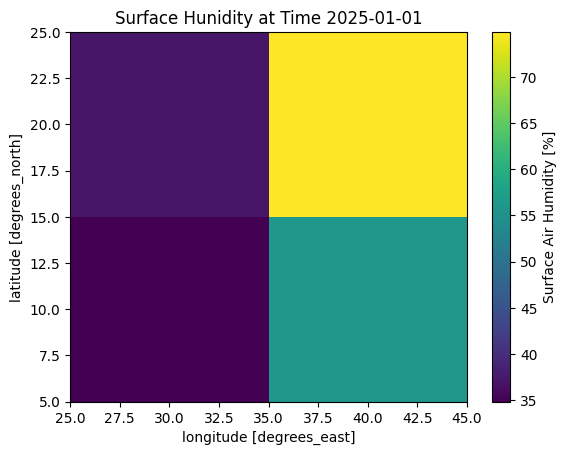

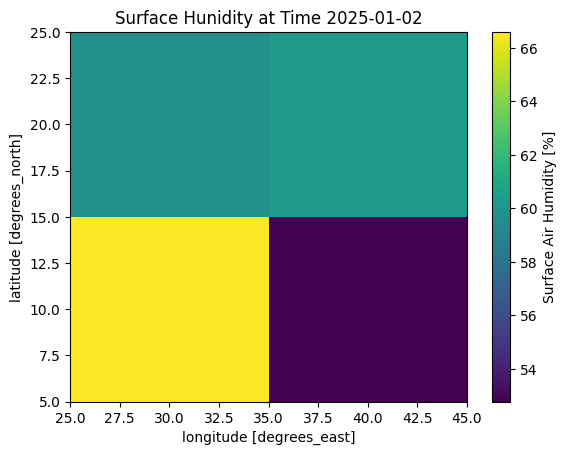

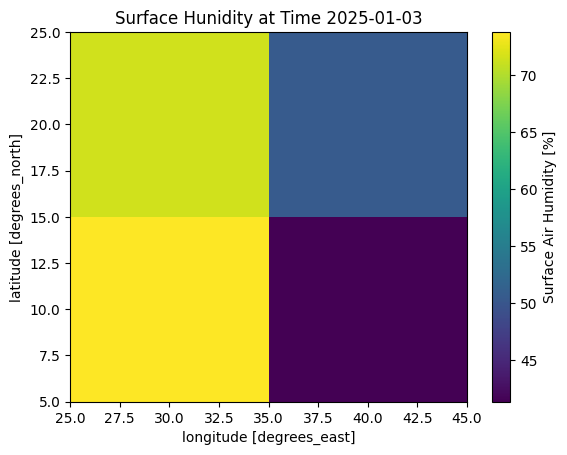

In [61]:
# all three day humidity
for t in range(len(humidity.time)):
    plt.figure()
    humidity.isel(time=t).plot()
    plt.title(f"Surface Hunidity at Time {str(humidity.time.values[t])[:10]}")
    plt.show()

### 4.3: Advance merge to reduce file size

We can reduce unnecessary data precision to reduce file size

- Reduce data precision: Convert `float 64` to `float 16`
- Data compression: Use zlib to compress data
- Datetime to date: drop the time part

In [65]:
files = ['day1.nc', 'day2.nc', 'day3.nc']
ad_merged_file_path = f"{tmp_path}/ad_merged_temperature.nc"

ad_data_list = []
for file in files:
    ds = xr.open_dataset(f"{tmp_path}/{file}", engine="netcdf4")

    # Reduce precision for variables
    ds["temperature"] = ds["temperature"].astype(np.float16)
    ds["humidity"] = ds["humidity"].astype(np.float16)

    # Convert time → integer days (truncate hours/minutes/seconds)
    if "time" in ds:
        # Floor to midnight
        ds["time"] = ds["time"].dt.floor("D")

        # Convert to int32: days since 1970-01-01
        ds["time"] = (ds["time"] - np.datetime64("1970-01-01")) \
            .astype("timedelta64[D]").astype("int32")

        # Add metadata
        ds["time"].attrs.update({
            "units": "days since 1970-01-01",
            "calendar": "standard"
        })

    ad_data_list.append(ds)

# Merge datasets via time dimension
ad_merged = xr.concat(ad_data_list, dim="time")

# Compression + precision settings
# Keep float32 in memory, but tell NetCDF to store as int16
encoding = {
    "temperature": {
        "zlib": True, "complevel": 4,
        "dtype": "i2",  # int16 storage
        "scale_factor": 0.01,  # resolution = 0.01 units
        "add_offset": 273.15,  # shift (e.g., Kelvin baseline)
        "_FillValue": -32767
    },
    "humidity": {
        "zlib": True, "complevel": 4,
        "dtype": "i2",  # int16 storage
        "scale_factor": 0.1,  # resolution = 0.1 %
        "add_offset": 0.0,
        "_FillValue": -32767
    },
    "time": {
        "zlib": True, "complevel": 4, "dtype": "i4"
    }
}

# Save merged dataset
ad_merged.to_netcdf(ad_merged_file_path, engine="netcdf4", encoding=encoding)

print(ad_merged)

<xarray.Dataset> Size: 92B
Dimensions:      (time: 3, lat: 2, lon: 2)
Coordinates:
  * lat          (lat) float64 16B 10.0 20.0
  * lon          (lon) float64 16B 30.0 40.0
  * time         (time) int32 12B 1735689600 1735776000 1735862400
Data variables:
    temperature  (time, lat, lon) float16 24B 286.8 282.2 289.2 ... 298.0 298.0
    humidity     (time, lat, lon) float16 24B 34.84 56.0 37.09 ... 71.38 50.53
Attributes:
    title:        Temperature sample Dataset
    institution:  CASD Meteorological Center
    source:       Simulated data
    history:      Created 2025-08-25
    Conventions:  CF-1.8
